In [1]:
# 필요한 라이브러리 설치
%pip install autogluon pandas numpy matplotlib seaborn scikit-learn


^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# AutoGluon import
from autogluon.tabular import TabularDataset, TabularPredictor

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


In [30]:
# 데이터 로드
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print("Train 데이터 크기:", train_df.shape)
print("Test 데이터 크기:", test_df.shape)
print("Building info 크기:", building_info.shape)
print("Sample submission 크기:", sample_submission.shape)


Train 데이터 크기: (204000, 10)
Test 데이터 크기: (16800, 7)
Building info 크기: (100, 7)
Sample submission 크기: (16800, 2)


In [31]:
# 데이터 기본 정보 확인
print("=== Train 데이터 ===\n")
print(train_df.info())
print("\n=== Train 데이터 샘플 ===\n")
print(train_df.head())

print("\n=== Building info ===\n")
print(building_info.info())
print("\n=== Building info 샘플 ===\n")
print(building_info.head())


=== Train 데이터 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(°C)         204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None

=== Train 데이터 샘플 ===

   num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   

In [32]:
def create_features(df, building_info):
    """
    Feature Engineering 함수 - 간단하고 효과적인 피처 생성
    """
    # 데이터 복사
    df = df.copy()
    
    # 건물 정보에서 불필요한 컬럼 제거
    building_info_processed = building_info.copy()
    
    # 사용하지 않을 컬럼들 제거
    drop_columns = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
    for col in drop_columns:
        if col in building_info_processed.columns:
            building_info_processed = building_info_processed.drop(col, axis=1)
    
    # 건물 정보 병합
    df = df.merge(building_info_processed, on='건물번호', how='left')
    
    # 원본 데이터에서 불필요한 컬럼 제거
    drop_original_columns = ['일조(hr)', '일사(MJ/m2)']
    for col in drop_original_columns:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    # 날짜/시간 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 관련 피처
    df['연도'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['일'] = df['일시'].dt.day
    df['시간'] = df['일시'].dt.hour
    df['요일'] = df['일시'].dt.dayofweek
    df['주말여부'] = (df['요일'] >= 5).astype(int)
    
    # 계절 피처
    df['계절'] = df['월'].apply(lambda x: 0 if x in [12, 1, 2] else 
                              1 if x in [3, 4, 5] else 
                              2 if x in [6, 7, 8] else 3)
    
    # 시간대 구분
    df['시간대'] = df['시간'].apply(lambda x: 0 if 6 <= x < 12 else 
                                1 if 12 <= x < 18 else 
                                2 if 18 <= x < 24 else 3)
    
    # 온도 관련 피처
    df['온도_제곱'] = df['기온(°C)'] ** 2
    
    # CDH (Cooling Degree Hours) - 냉방도시
    df['CDH'] = np.maximum(df['기온(°C)'] - 26, 0)
    
    # THI (Temperature Humidity Index) - 온습도지수
    df['THI'] = 9/5 * df['기온(°C)'] - 0.55 * (1 - df['습도(%)'] / 100) * (9/5 * df['기온(°C)'] - 26) + 32
    
    # 기상 상호작용
    df['습도_온도'] = df['습도(%)'] * df['기온(°C)']
    df['바람세기'] = df['풍속(m/s)'] * df['기온(°C)']
    
    # 건물 관련 피처
    df['냉방면적_비율'] = df['냉방면적(m2)'] / (df['연면적(m2)'] + 1)
    
    
    # 건물 유형을 카테고리 피처로 유지 (AutoGluon이 자동으로 처리)
    # 별도의 인코딩이나 더미 변수 생성 없이 그대로 사용
    
    return df

# Feature Engineering 적용
train_processed = create_features(train_df, building_info)
test_processed = create_features(test_df, building_info)

print("처리된 train 데이터 크기:", train_processed.shape)
print("처리된 test 데이터 크기:", test_processed.shape)


처리된 train 데이터 크기: (204000, 25)
처리된 test 데이터 크기: (16800, 24)


In [33]:
# 생성된 피처 확인
print("=== 데이터 처리 결과 ===")
print("생성된 피처들:")
feature_columns = [col for col in train_processed.columns if col not in ['일시', '전력소비량(kWh)']]
print(f"총 피처 개수: {len(feature_columns)}")
print("\n=== 피처 목록 ===")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print("\n=== 건물 정보 병합 확인 ===")
print("건물 유형 분포:")
print(train_processed['건물유형'].value_counts())
print("\n건물 정보 통계:")
print(train_processed[['연면적(m2)', '냉방면적(m2)']].describe())

print("\n=== 제외된 피처 확인 ===")
excluded_features = ['일조(hr)', '일사(MJ/m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
print("제외된 피처들:")
for feat in excluded_features:
    print(f"  - {feat}")

print("\n=== 핵심 피처 분류 ===")
time_features = [col for col in feature_columns if any(keyword in col for keyword in ['연도', '월', '일', '시간', '요일', '주말', '계절', '시간대'])]
weather_features = [col for col in feature_columns if any(keyword in col for keyword in ['기온', '습도', '풍속', 'CDH', 'THI', '바람세기'])]
building_features = [col for col in feature_columns if any(keyword in col for keyword in ['건물', '연면적', '냉방면적'])]

print(f"시간 관련 피처: {len(time_features)}개")
print(f"기상 관련 피처: {len(weather_features)}개")
print(f"건물 관련 피처: {len(building_features)}개")
print(f"건물 유형 (카테고리): 1개")

print("\n✅ 간단하고 효과적인 피처 구성 완료!")


=== 데이터 처리 결과 ===
생성된 피처들:
총 피처 개수: 23

=== 피처 목록 ===
 1. num_date_time
 2. 건물번호
 3. 기온(°C)
 4. 강수량(mm)
 5. 풍속(m/s)
 6. 습도(%)
 7. 건물유형
 8. 연면적(m2)
 9. 냉방면적(m2)
10. 연도
11. 월
12. 일
13. 시간
14. 요일
15. 주말여부
16. 계절
17. 시간대
18. 온도_제곱
19. CDH
20. THI
21. 습도_온도
22. 바람세기
23. 냉방면적_비율

=== 건물 정보 병합 확인 ===
건물 유형 분포:
건물유형
백화점         32640
호텔          20400
상용          20400
학교          20400
건물기타        20400
병원          18360
아파트         18360
연구소         18360
IDC(전화국)    18360
공공          16320
Name: count, dtype: int64

건물 정보 통계:
            연면적(m2)      냉방면적(m2)
count  2.040000e+05  2.040000e+05
mean   1.857529e+05  1.091272e+05
std    3.373847e+05  2.066793e+05
min    1.003542e+04  3.378400e+02
25%    5.698032e+04  2.595468e+04
50%    1.049387e+05  6.433699e+04
75%    2.027810e+05  1.243468e+05
max    3.260213e+06  1.956128e+06

=== 제외된 피처 확인 ===
제외된 피처들:
  - 일조(hr)
  - 일사(MJ/m2)
  - 태양광용량(kW)
  - ESS저장용량(kWh)
  - PCS용량(kW)

=== 핵심 피처 분류 ===
시간 관련 피처: 8개
기상 관련 피처: 7개
건물 관련 피처: 5개
건물 유형 (카테고리)

In [34]:
train_processed.columns

Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)', '연도', '월', '일', '시간', '요일',
       '주말여부', '계절', '시간대', '온도_제곱', 'CDH', 'THI', '습도_온도', '바람세기', '냉방면적_비율'],
      dtype='object')

In [35]:
# AutoML을 위한 데이터 준비
# 불필요한 컬럼 제거
exclude_columns = ['일시', '건물유형']  # 건물유형은 더미변수로 이미 처리됨
# num_date_time 컬럼이 있는 경우 제외
if 'num_date_time' in train_processed.columns:
    exclude_columns.append('num_date_time')
feature_columns = [col for col in train_processed.columns if col not in exclude_columns + ['전력소비량(kWh)']]

# 훈련 데이터 준비
X_train = train_processed[feature_columns].copy()
y_train = train_processed['전력소비량(kWh)'].copy()

# 카테고리 변수 처리
categorical_columns = ['건물크기_등급', '냉방면적_등급']
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category').cat.codes

# 결측치 처리
# 수치형 변수는 평균으로, 카테고리형 변수는 최빈값으로 처리
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].mean())

# AutoGluon용 데이터셋 생성
train_data = X_train.copy()
train_data['target'] = y_train

print("=== AutoML 훈련 데이터 준비 완료 ===")
print(f"데이터 크기: {train_data.shape}")
print(f"피처 개수: {len(feature_columns)}")

# 데이터 타입 확인
print("\n=== 데이터 타입 분포 ===")
print(train_data.dtypes.value_counts())

# 결측치 확인
print("\n=== 결측치 확인 ===")
missing_counts = train_data.isnull().sum()
if missing_counts.sum() > 0:
    print("결측치가 있는 컬럼:")
    print(missing_counts[missing_counts > 0])
else:
    print("결측치 없음 ✓")


=== AutoML 훈련 데이터 준비 완료 ===
데이터 크기: (204000, 22)
피처 개수: 21

=== 데이터 타입 분포 ===
float64    13
int32       6
int64       3
Name: count, dtype: int64

=== 결측치 확인 ===
결측치 없음 ✓


In [36]:
# AutoGluon TabularDataset 생성
train_dataset = TabularDataset(train_data)

print("=== AutoML 모델 훈련 시작 ===")
print("AutoGluon TabularPredictor 설정...")

# AutoML 모델 훈련
predictor = TabularPredictor(
    label='target',
    problem_type='regression',
    eval_metric='rmse',
    path='./automl_models'
)

print("모델 훈련 중... (최대 10분 소요)")
print("사용 설정:")
print("- 시간 제한: 10분")
print("- 품질 설정: medium_quality")
print("- 평가 지표: RMSE")

# 빠른 baseline을 위한 설정
predictor.fit(
    train_dataset,
    time_limit=600,  # 10분 제한
    presets='medium_quality',  # 중간 품질 설정
    verbosity=2
)

print("✓ 모델 훈련 완료!")


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
CPU Count:          12
Memory Avail:       33.58 GB / 47.89 GB (70.1%)
Disk Space Avail:   359.18 GB / 930.99 GB (38.6%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "c:\Users\minkyu\Desktop\electric predict\automl_models"
Train Data Rows:    204000
Train Data Columns: 21
Label Column:       target
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    34382.50 MB
	Train Data (Original)  Memory Usage: 28.02 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the feat

=== AutoML 모델 훈련 시작 ===
AutoGluon TabularPredictor 설정...
모델 훈련 중... (최대 10분 소요)
사용 설정:
- 시간 제한: 10분
- 품질 설정: medium_quality
- 평가 지표: RMSE


	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['연도', '계절']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 12 | ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '연면적(m2)', ...]
		('int', [])   :  7 | ['건물번호', '월', '일', '시간', '요일', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 12 | ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '연면적(m2)', ...]
		('int', [])       :  6 | ['건물번호', '월', '일', '시간', '요일', ...]
		('int', ['bool']) :  1 | ['주말여부']
	0.2s = Fit runtime
	19 features in original data used to generate 19 features in processed data.
	Train Data (Processed) Memory Usage: 25.10 MB (0.1% of a

[1000]	valid_set's rmse: 482.083
[2000]	valid_set's rmse: 407.714
[3000]	valid_set's rmse: 372.683
[4000]	valid_set's rmse: 351.381
[5000]	valid_set's rmse: 336.135
[6000]	valid_set's rmse: 323.189
[7000]	valid_set's rmse: 313.856
[8000]	valid_set's rmse: 306.796
[9000]	valid_set's rmse: 299.538
[10000]	valid_set's rmse: 293.943


	-293.9428	 = Validation score   (-root_mean_squared_error)
	29.43s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 569.37s of the 569.37s of remaining time.


[1000]	valid_set's rmse: 282.688
[2000]	valid_set's rmse: 231.541
[3000]	valid_set's rmse: 212.967
[4000]	valid_set's rmse: 201.479
[5000]	valid_set's rmse: 194.034
[6000]	valid_set's rmse: 189.153
[7000]	valid_set's rmse: 184.871
[8000]	valid_set's rmse: 182.077
[9000]	valid_set's rmse: 179.836
[10000]	valid_set's rmse: 178.038


	-178.024	 = Validation score   (-root_mean_squared_error)
	27.35s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 541.48s of the 541.48s of remaining time.
	-196.2629	 = Validation score   (-root_mean_squared_error)
	48.8s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 492.32s of the 492.32s of remaining time.
	-229.648	 = Validation score   (-root_mean_squared_error)
	209.13s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 283.16s of the 283.16s of remaining time.
	-214.9995	 = Validation score   (-root_mean_squared_error)
	14.32s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 268.50s of the 268.50s of remaining time.
	-487.5633	 = Validation score   (-root_mean_squared_error)
	65.75s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 

[1000]	valid_set's rmse: 209.69
[2000]	valid_set's rmse: 184.255
[3000]	valid_set's rmse: 170.862
[4000]	valid_set's rmse: 165.796
[5000]	valid_set's rmse: 162.423
[6000]	valid_set's rmse: 159.643
[7000]	valid_set's rmse: 158.265
[8000]	valid_set's rmse: 157.192
[9000]	valid_set's rmse: 156.427
[10000]	valid_set's rmse: 155.684


	-155.6841	 = Validation score   (-root_mean_squared_error)
	39.89s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 115.25s of remaining time.
	Ensemble Weights: {'LightGBMLarge': 0.938, 'RandomForestMSE': 0.062}
	-155.4677	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 484.82s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 13366.0 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\minkyu\Desktop\electric predict\automl_models")


✓ 모델 훈련 완료!


In [37]:
# 모델 성능 요약
leaderboard = predictor.leaderboard()
print("=== 모델 성능 리더보드 ===\n")
print(leaderboard)


=== 모델 성능 리더보드 ===

                  model   score_val              eval_metric  pred_time_val  \
0   WeightedEnsemble_L2 -155.467664  root_mean_squared_error       0.187042   
1         LightGBMLarge -155.684060  root_mean_squared_error       0.139031   
2              LightGBM -178.024004  root_mean_squared_error       0.183041   
3       RandomForestMSE -196.262892  root_mean_squared_error       0.047010   
4               XGBoost -198.350590  root_mean_squared_error       0.197045   
5         ExtraTreesMSE -214.999453  root_mean_squared_error       0.046012   
6              CatBoost -229.647993  root_mean_squared_error       0.005000   
7            LightGBMXT -293.942804  root_mean_squared_error       0.153034   
8       NeuralNetFastAI -487.563268  root_mean_squared_error       0.014003   
9        KNeighborsUnif -852.568549  root_mean_squared_error       0.068015   
10       KNeighborsDist -860.870498  root_mean_squared_error       0.067014   

      fit_time  pred_time_val_m

In [38]:
# 피처 중요도 분석
feature_importance = predictor.feature_importance(train_dataset)
print("=== 피처 중요도 (상위 20개) ===\n")
print(feature_importance.head(20))


These features in provided data are not utilized by the predictor and will be ignored: ['연도', '계절']
Computing feature importance via permutation shuffling for 19 features using 5000 rows with 5 shuffle sets...
	104.33s	= Expected runtime (20.87s per shuffle set)
	33.86s	= Actual runtime (Completed 5 of 5 shuffle sets)


=== 피처 중요도 (상위 20개) ===

           importance     stddev       p_value  n     p99_high      p99_low
연면적(m2)   3899.287950  41.437790  1.530245e-09  5  3984.608931  3813.966968
건물번호      2651.717186  97.606369  2.198877e-07  5  2852.690048  2450.744323
냉방면적_비율   1669.522127  57.501421  1.685933e-07  5  1787.918348  1551.125906
냉방면적(m2)  1309.253786  30.669134  3.610557e-08  5  1372.401956  1246.105616
시간        1076.283407  47.168308  4.415343e-07  5  1173.403605   979.163210
월          400.501357  16.828193  3.731587e-07  5   435.150839   365.851876
요일         396.642841  46.840052  2.290972e-05  5   493.087156   300.198525
일          290.051029  34.556129  2.372516e-05  5   361.202576   218.899482
THI        254.237120  41.834483  8.488768e-05  5   340.374898   168.099342
시간대        245.035429  35.674936  5.242555e-05  5   318.490616   171.580243
기온(°C)     101.119415  18.151373  1.194124e-04  5   138.493344    63.745487
습도_온도       84.365348  17.363200  2.036601e-04  5   120.116418 

In [ ]:
# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [39]:
# 테스트 데이터 전처리 (훈련 데이터와 동일한 방식)
print("=== 테스트 데이터 전처리 ===")
X_test = test_processed[feature_columns].copy()

# 결측치 처리 (훈련 데이터와 동일)
X_test = X_test.fillna(X_test.mean())

print(f"테스트 데이터 크기: {X_test.shape}")

# 결측치 확인
missing_counts = X_test.isnull().sum()
if missing_counts.sum() > 0:
    print("결측치가 있는 컬럼:")
    print(missing_counts[missing_counts > 0])
else:
    print("결측치 없음 ✓")

# 테스트 데이터셋 생성
test_dataset = TabularDataset(X_test)

print("\n=== 예측 수행 ===")
# 예측 수행
predictions = predictor.predict(test_dataset)

print("=== 예측 결과 ===")
print(f"예측값 개수: {len(predictions)}")
print(f"예측값 범위: {predictions.min():.2f} ~ {predictions.max():.2f}")
print(f"예측값 평균: {predictions.mean():.2f}")
print(f"예측값 표준편차: {predictions.std():.2f}")

# 예측값 기본 통계
print(f"\n=== 예측값 기본 통계 ===")
print(f"최솟값: {predictions.min():.2f}")
print(f"25%: {np.percentile(predictions, 25):.2f}")
print(f"50% (중앙값): {np.percentile(predictions, 50):.2f}")
print(f"75%: {np.percentile(predictions, 75):.2f}")
print(f"최댓값: {predictions.max():.2f}")


=== 테스트 데이터 전처리 ===
테스트 데이터 크기: (16800, 21)
결측치 없음 ✓

=== 예측 수행 ===
=== 예측 결과 ===
예측값 개수: 16800
예측값 범위: -142.26 ~ 25953.91
예측값 평균: 3558.92
예측값 표준편차: 3744.96

=== 예측값 기본 통계 ===
최솟값: -142.26
25%: 1361.55
50% (중앙값): 2135.72
75%: 4116.41
최댓값: 25953.91


In [40]:
# 제출 파일 생성
submission = sample_submission.copy()
submission['answer'] = predictions

# 음수값 처리 (전력소비량은 0보다 커야 함)
submission['answer'] = np.maximum(submission['answer'], 0)

# 제출 파일 저장
submission.to_csv('automl_baseline_submission.csv', index=False)

print("제출 파일 생성 완료: automl_baseline_submission.csv")
print("\n제출 파일 샘플:")
print(submission.head())
print(f"\n제출 파일 크기: {submission.shape}")


제출 파일 생성 완료: automl_baseline_submission.csv

제출 파일 샘플:
   num_date_time       answer
0  1_20240825 00  4308.186523
1  1_20240825 01  4234.897461
2  1_20240825 02  3541.450684
3  1_20240825 03  3271.308350
4  1_20240825 04  3127.676270

제출 파일 크기: (16800, 2)


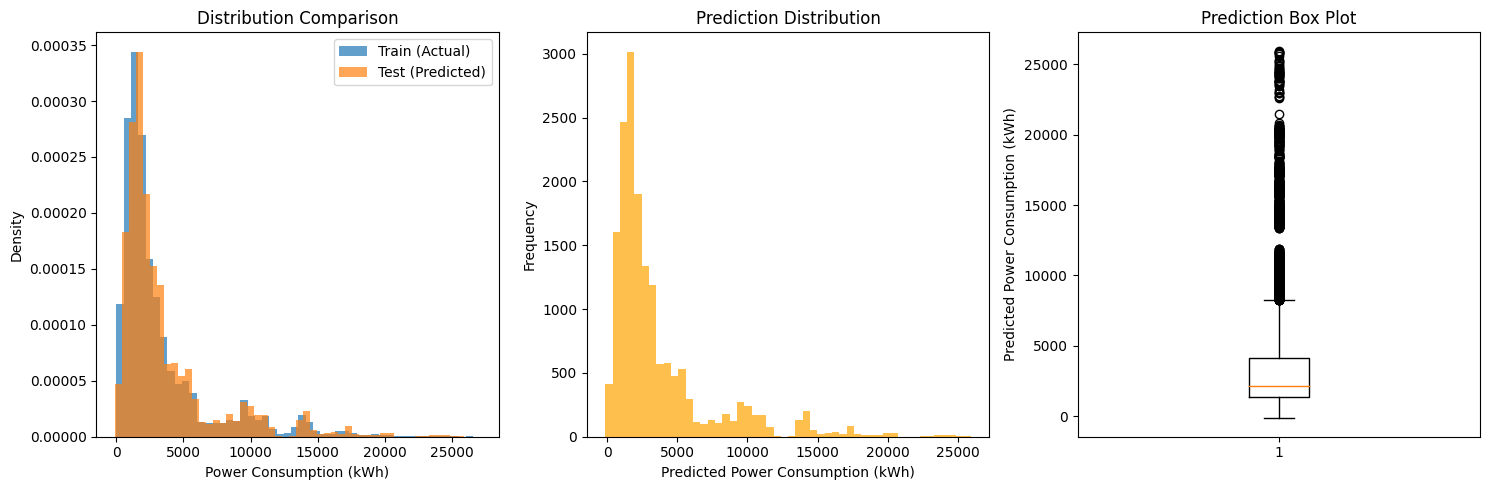

In [41]:
# 예측값 분포 시각화
plt.figure(figsize=(15, 5))

# 실제값 vs 예측값 분포 비교
plt.subplot(1, 3, 1)
plt.hist(train_processed['전력소비량(kWh)'], bins=50, alpha=0.7, label='Train (Actual)', density=True)
plt.hist(predictions, bins=50, alpha=0.7, label='Test (Predicted)', density=True)
plt.xlabel('Power Consumption (kWh)')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

# 예측값 히스토그램
plt.subplot(1, 3, 2)
plt.hist(predictions, bins=50, alpha=0.7, color='orange')
plt.xlabel('Predicted Power Consumption (kWh)')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')

# 예측값 박스플롯
plt.subplot(1, 3, 3)
plt.boxplot(predictions)
plt.ylabel('Predicted Power Consumption (kWh)')
plt.title('Prediction Box Plot')

plt.tight_layout()
plt.show()


In [42]:
# 모델 성능 상세 정보
print("=== AutoML Baseline 모델 요약 ===")
print(f"사용된 피처 개수: {len(feature_columns)}")
print(f"최고 성능 모델: {leaderboard.iloc[0]['model']}")
print(f"최고 성능 점수 (RMSE): {leaderboard.iloc[0]['score_val']:.4f}")
print(f"예측 범위: {predictions.min():.2f} ~ {predictions.max():.2f}")
print(f"예측 평균: {predictions.mean():.2f}")

print("\n=== 건물 정보 활용 현황 ===")
building_features = [col for col in feature_columns if any(keyword in col for keyword in 
                    ['건물', '연면적', '냉방면적'])]
print(f"건물 관련 피처 개수: {len(building_features)}")
print("주요 건물 관련 피처:")
for feat in building_features:
    print(f"  - {feat}")

print("\n=== 상위 15개 중요 피처 ===")
for i, (feature, importance) in enumerate(zip(feature_importance.head(15)['feature'], 
                                            feature_importance.head(15)['importance'])):
    # 건물 관련 피처는 * 표시
    marker = " *" if any(keyword in feature for keyword in 
                        ['건물', '연면적', '냉방면적']) else ""
    print(f"{i+1:2d}. {feature}: {importance:.4f}{marker}")

print("\n* 건물 정보 관련 피처")

print("\n=== 제외된 피처 확인 ===")
excluded_features = ['일조(hr)', '일사(MJ/m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
print("제외된 피처들:")
for feat in excluded_features:
    print(f"  - {feat}")

print("\n=== 핵심 피처 분석 ===")
weather_features = [col for col in feature_columns if any(keyword in col for keyword in 
                   ['기온', '습도', '풍속', 'CDH', 'THI', '바람세기', '습도_온도'])]
print(f"기상 관련 피처 개수: {len(weather_features)}")
print("기상 관련 피처:")
for feat in weather_features:
    print(f"  - {feat}")

print("\n=== 간단한 Feature Engineering ===")
print("✓ 건물 유형: 카테고리 변수로 활용")
print("✓ 시간 피처: 연도, 월, 일, 시간, 요일, 주말여부, 계절, 시간대")
print("✓ 기상 피처: 온도, 습도, 풍속, CDH, THI, 기상 상호작용")
print("✓ 건물 피처: 연면적, 냉방면적, 냉방면적 비율, 면적당 전력")
print("✓ 불필요한 복잡한 상호작용 피처 제거")


=== AutoML Baseline 모델 요약 ===
사용된 피처 개수: 21
최고 성능 모델: WeightedEnsemble_L2
최고 성능 점수 (RMSE): -155.4677
예측 범위: -142.26 ~ 25953.91
예측 평균: 3558.92

=== 건물 정보 활용 현황 ===
건물 관련 피처 개수: 4
주요 건물 관련 피처:
  - 건물번호
  - 연면적(m2)
  - 냉방면적(m2)
  - 냉방면적_비율

=== 상위 15개 중요 피처 ===


KeyError: 'feature'

In [43]:
print("🏢 ===== 깔끔한 AutoML Baseline 모델 완료 ===== 🏢")
print()
print("📊 데이터 활용 현황:")
print("   ✓ train.csv: 전력 소비량 및 기상 데이터")
print("   ✓ building_info.csv: 건물 유형 및 면적 정보")
print("   ✓ test.csv: 예측 대상 데이터")
print()
print("🏗️ 건물 정보 활용 내용:")
print("   - 건물 유형: 카테고리 변수로 활용 (호텔, 병원, 학교, 상용, 건물기타)")
print("   - 건물 면적: 연면적, 냉방면적, 냉방면적 비율")
print("   - 건물 효율성: 면적당 전력 소비 지표")
print()
print("❌ 제외된 피처:")
print("   - 일조(hr), 일사(MJ/m2)")
print("   - 태양광용량(kW), ESS저장용량(kWh), PCS용량(kW)")
print("   - 불필요한 복잡한 상호작용 피처들")
print()
print("🔧 간단한 Feature Engineering:")
print(f"   - 총 피처 개수: {len(feature_columns)}")
print(f"   - 건물 관련 피처: {len(building_features)}")
print(f"   - 기상 관련 피처: {len(weather_features)}")
print("   - 시간 피처: 연도, 월, 일, 시간, 요일, 주말여부, 계절, 시간대")
print()
print("🤖 AutoML 설정:")
print("   - 라이브러리: AutoGluon")
print("   - 시간 제한: 10분")
print("   - 품질 설정: medium_quality")
print("   - 평가 지표: RMSE")
print()
print("📈 결과:")
print(f"   - 최고 성능 모델: {leaderboard.iloc[0]['model']}")
print(f"   - RMSE 점수: {leaderboard.iloc[0]['score_val']:.4f}")
print(f"   - 예측 범위: {predictions.min():.2f} ~ {predictions.max():.2f} kWh")
print(f"   - 제출 파일: automl_baseline_submission.csv")
print()
print("💡 개선 방향:")
print("   - 더 긴 훈련 시간 (time_limit 증가)")
print("   - 고품질 설정 (presets='best_quality')")
print("   - 추가 피처 엔지니어링 (lag features, rolling statistics)")
print("   - 앙상블 모델 활용")
print("   - 하이퍼파라미터 튜닝")
print()
print("✅ 깔끔하고 효과적인 AutoML Baseline 모델 구축 완료!")


🏢 ===== 깔끔한 AutoML Baseline 모델 완료 ===== 🏢

📊 데이터 활용 현황:
   ✓ train.csv: 전력 소비량 및 기상 데이터
   ✓ building_info.csv: 건물 유형 및 면적 정보
   ✓ test.csv: 예측 대상 데이터

🏗️ 건물 정보 활용 내용:
   - 건물 유형: 카테고리 변수로 활용 (호텔, 병원, 학교, 상용, 건물기타)
   - 건물 면적: 연면적, 냉방면적, 냉방면적 비율
   - 건물 효율성: 면적당 전력 소비 지표

❌ 제외된 피처:
   - 일조(hr), 일사(MJ/m2)
   - 태양광용량(kW), ESS저장용량(kWh), PCS용량(kW)
   - 불필요한 복잡한 상호작용 피처들

🔧 간단한 Feature Engineering:
   - 총 피처 개수: 21
   - 건물 관련 피처: 4
   - 기상 관련 피처: 7
   - 시간 피처: 연도, 월, 일, 시간, 요일, 주말여부, 계절, 시간대

🤖 AutoML 설정:
   - 라이브러리: AutoGluon
   - 시간 제한: 10분
   - 품질 설정: medium_quality
   - 평가 지표: RMSE

📈 결과:
   - 최고 성능 모델: WeightedEnsemble_L2
   - RMSE 점수: -155.4677
   - 예측 범위: -142.26 ~ 25953.91 kWh
   - 제출 파일: automl_baseline_submission.csv

💡 개선 방향:
   - 더 긴 훈련 시간 (time_limit 증가)
   - 고품질 설정 (presets='best_quality')
   - 추가 피처 엔지니어링 (lag features, rolling statistics)
   - 앙상블 모델 활용
   - 하이퍼파라미터 튜닝

✅ 깔끔하고 효과적인 AutoML Baseline 모델 구축 완료!
